# Module 4: Push Notifications DS

## Import libraries

In [78]:
import os
import sys
import boto3
import logging
import numpy as np
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
from scipy.stats import randint, uniform

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, confusion_matrix

sys.path.append(str(Path().resolve().parent))

from utils import temporal_split_by_order

logging.basicConfig(
    level=logging.INFO,  # Info level for general information
    format="%(asctime)s - %(levelname)s - %(message)s",
)

## Load dataset

Download the dataset if it doesn't already exist in the machine.

In [64]:
load_dotenv()
AWW_API_KEY = os.getenv("AWW_API_KEY")
AWW_SECRET = os.getenv("AWW_SECRET")

s3 = boto3.client(
    's3',
    aws_access_key_id=AWW_API_KEY,
    aws_secret_access_key=AWW_SECRET
)
bucket_name = 'zrive-ds-data'
prefix = "groceries/box_builder_dataset/"

PROJECT_ROOT = Path().resolve().parent.parent
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

logging.info(f"Data folder: {DATA_DIR}")

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

for obj in response.get("Contents", []):
    file_key = obj["Key"]
    if file_key.endswith("/"):  # skip folder placeholders
        continue

    # Strip the first folder ('groceries/') and keep the inner folders
    relative_path = Path(*file_key.split("/")[1:])
    local_path = DATA_DIR / relative_path
    local_path.parent.mkdir(parents=True, exist_ok=True)

    if local_path.exists():
        logging.info(f"Already exists: {local_path}, skipping download.")
    else:
        s3.download_file(bucket_name, file_key, str(local_path))
        logging.info(f"Downloaded {local_path}")

2025-11-02 16:35:09,472 - INFO - Data folder: /Users/maria/Desktop/Zrive DS/zrive-ds/data
2025-11-02 16:35:09,850 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/box_builder_dataset/feature_frame.csv, skipping download.


In [65]:
df = pd.read_csv(DATA_DIR / "box_builder_dataset" / "feature_frame.csv")
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


## Milestone 1: exploration phase

### Filter to at least 5 items bought

In [66]:
orders_with_5plus = (
    df[df["outcome"] == 1]              # only buy orders
      .groupby("order_id")["variant_id"]
      .nunique()                        # count unique variant_id por order_id
      .loc[lambda x: x >= 5]            # take >= 5 items
      .index                            # get the order_id index
)

df_filtered = df[df["order_id"].isin(orders_with_5plus)]


In [67]:
logging.info(f"Original dataset size: {df.shape[0]} rows")
logging.info(f"Filtered dataset size: {df_filtered.shape[0]} rows")
df_filtered.head()

2025-11-02 16:35:21,799 - INFO - Original dataset size: 2880549 rows
2025-11-02 16:35:21,802 - INFO - Filtered dataset size: 2163953 rows


,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


### Prepare the data

Now, we split the data intro train (70%), validation (20%) and test (10%). We apply a temporal split because the number of orders increases over time, likely due to new customers joining. New customers may behave differently from early ones, so a time-based split better reflects real future scenarios.

/var/folders/45/_kywt6y9647bq9fvcw_fkvrw0000gn/T/ipykernel_71355/1956584805.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['order_date'] = pd.to_datetime(df_filtered['order_date'])


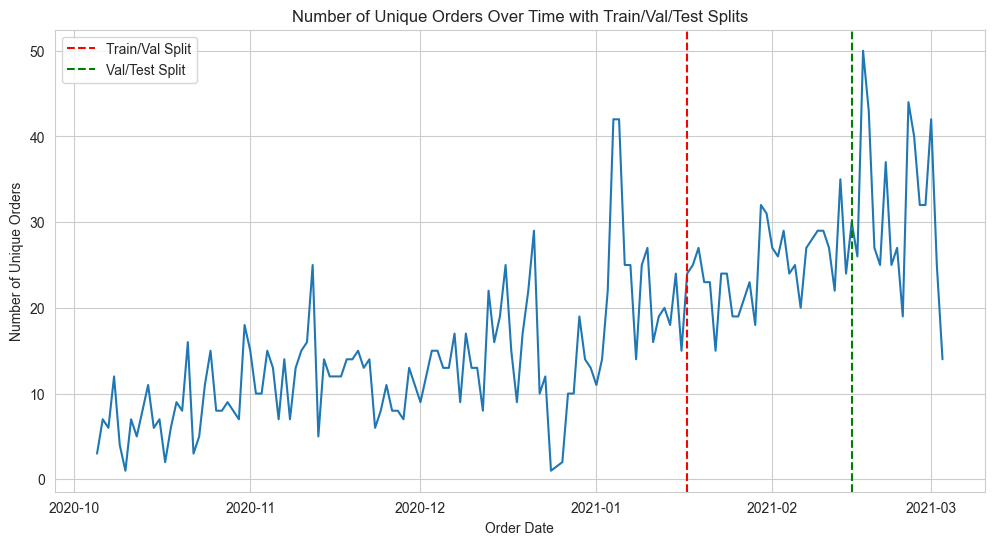

In [68]:
df_filtered['order_date'] = pd.to_datetime(df_filtered['order_date'])
orders_per_date = df_filtered.groupby('order_date')['order_id'].nunique().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=orders_per_date, x="order_date", y="order_id", ax=ax)

# Vertical lines for splits
train_size = int(0.7 * len(orders_per_date))
val_size = int(0.2 * len(orders_per_date))
train_end_date = orders_per_date["order_date"].iloc[train_size - 1]
val_end_date = orders_per_date["order_date"].iloc[train_size + val_size - 1]
ax.axvline(x=train_end_date, color="r", linestyle="--", label="Train/Val Split")
ax.axvline(x=val_end_date, color="g", linestyle="--", label="Val/Test Split")

ax.legend()
ax.set_title("Number of Unique Orders Over Time with Train/Val/Test Splits")
ax.set_xlabel("Order Date")
ax.set_ylabel("Number of Unique Orders")
plt.show()

In [69]:
X_train, X_val, X_test, y_train, y_val, y_test = temporal_split_by_order(
    df=df_filtered,
    date_col="order_date",
    order_col="order_id",
    feature_cols=["product_type", "ordered_before", "abandoned_before", "active_snoozed", "set_as_regular", "global_popularity"],
    target_col="outcome"
)
logging.info(f"Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

2025-11-02 16:35:23,403 - INFO - Total unique orders: 2603
2025-11-02 16:35:23,403 - INFO - Train orders: 1822 (70.0%)
2025-11-02 16:35:23,404 - INFO - Val orders: 520 (20.0%)
2025-11-02 16:35:23,405 - INFO - Test orders: 261 (10.0%)
2025-11-02 16:35:23,406 - INFO - Train rows: 1446691, Val rows: 466801, Test rows: 250461
2025-11-02 16:35:23,437 - INFO - Shapes -> Train: (1446691, 6), Val: (466801, 6), Test: (250461, 6)


The next step is transforming the categorical features into numericals to train the model. As we have so many categories in `product_type` one-hot encoding would increase the df size a lot, so we have to use a different encoding method. Instead, we apply frequency encoding. Other methods, such as label encoding, were discarded because it assigns unique numbers to each category, which can wrongly suggest a hierarchy or order between them. This may confuse the model into treating some categories as 'greater' or 'less' than others, even when no such relationship exists.

In [70]:
freq_map = X_train["product_type"].value_counts(normalize=True)
X_train["product_type"] = X_train["product_type"].map(freq_map)
X_val["product_type"] = X_val["product_type"].map(freq_map).fillna(0)
X_test["product_type"] = X_test["product_type"].map(freq_map).fillna(0)

logging.info("Applied frequency encoding to 'product_type'")

2025-11-02 16:35:23,790 - INFO - Applied frequency encoding to 'product_type'


Lastly, we scale the data, which is very important for models like Ridge and Lasso since they penalise high weights.

In [71]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

The dataset is highly imbalanced, with very few positive samples compared to negative ones. To address this issue and help the model learn from minority cases, we apply SMOTE, which generates synthetic examples of the minority class instead of simply duplicating existing ones.

In [72]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
logging.info(f"After SMOTE: {np.bincount(y_train_res)}")

2025-11-02 16:35:26,884 - INFO - After SMOTE: [1424909 1424909]


### Baseline model

We can use a feature, such as `global popularity`, as a baseline model. That way, we can compare the metrics to understand if the model improves.

In [73]:
X_train_res_df = pd.DataFrame(X_train_res, columns=X_train.columns)

gp = X_val['global_popularity']
roc_auc = roc_auc_score(y_val, gp)
pr_auc = average_precision_score(y_val, gp)
logging.info(f"Global Popularity - ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")

2025-11-02 16:35:27,519 - INFO - Global Popularity - ROC-AUC: 0.7867, PR-AUC: 0.0667


### Non-linear models: ensembles

#### Random Forest

The first model we are going to test is Random Forest, which is an ensemble of decision trees.

In [74]:
param_dist = {
    "n_estimators": randint(50, 150),
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=8,
    cv=2,
    scoring="roc_auc",
    random_state=42,
    verbose=1,
)

search.fit(X_train_res, y_train_res)

best_rf = search.best_estimator_
logging.info(f"Best parameters: {search.best_params_}")

y_val_pred_rf = best_rf.predict(X_val_scaled)

rf_report = classification_report(y_val, y_val_pred_rf)
logging.info("Random Forest Classifier - Validation Set Classification Report:\n" + rf_report)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


2025-11-02 16:51:28,702 - INFO - Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 132}
2025-11-02 16:51:32,283 - INFO - Random Forest Classifier - Validation Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.52      0.68    460469
         1.0       0.02      0.62      0.03      6332

    accuracy                           0.52    466801
   macro avg       0.50      0.57      0.36    466801
weighted avg       0.98      0.52      0.67    466801



In [76]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_rf.feature_importances_
}).sort_values("importance", ascending=False)

print(importance)

             feature  importance
5  global_popularity    0.748646
0       product_type    0.113119
1     ordered_before    0.108370
2   abandoned_before    0.020577
4     set_as_regular    0.006898
3     active_snoozed    0.002390


#### Gradient Boosting Trees

Now, we try Gradient Voosting Trees, which is another ensemble of trees.

In [80]:
param_dist = {
    "n_estimators": randint(50, 150),
    "learning_rate": uniform(0.05, 0.2),
    "max_depth": [2, 4],
}

gb = GradientBoostingClassifier(random_state=42)

search = RandomizedSearchCV(
    gb,
    param_distributions=param_dist,
    n_iter=8,
    cv=2,
    scoring="roc_auc",
    random_state=42,
    verbose=1,
)

search.fit(X_train_res, y_train_res)

best_gb = search.best_estimator_
logging.info(f"Best parameters: {search.best_params_}")

y_val_pred_gb = best_gb.predict(X_val_scaled)

gb_report = classification_report(y_val, y_val_pred_gb)
logging.info("Gradient Boosting Classifier - Validation Set Classification Report:\n" + gb_report)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


2025-11-02 20:25:08,790 - INFO - Best parameters: {'learning_rate': 0.07857336358438816, 'max_depth': 2, 'n_estimators': 71}
2025-11-02 20:25:12,936 - INFO - Gradient Boosting Classifier - Validation Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.90    460469
         1.0       0.05      0.68      0.09      6332

    accuracy                           0.81    466801
   macro avg       0.52      0.75      0.49    466801
weighted avg       0.98      0.81      0.88    466801



In [82]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_gb.feature_importances_
}).sort_values("importance", ascending=False)

print(importance)

             feature  importance
5  global_popularity    0.715388
1     ordered_before    0.235425
2   abandoned_before    0.039737
4     set_as_regular    0.007841
0       product_type    0.000951
3     active_snoozed    0.000658


### Conclusions

The Gradient Boosting model performs better, mainly in Recall. That means that it is able to correctly identify a higher proportion of positive cases (the minority class) compared to the Random Forest.

#### Confusion matrices

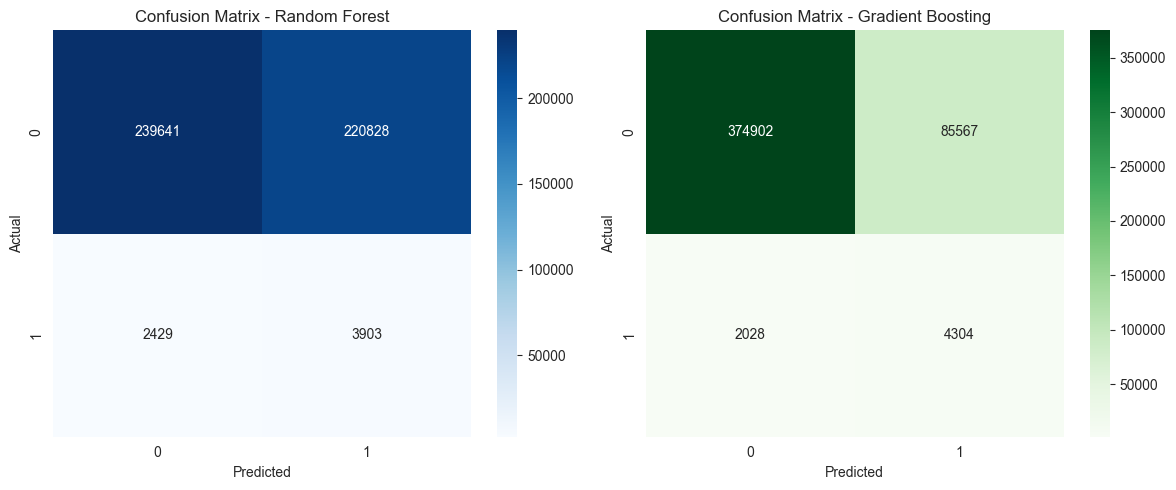

In [83]:
cm_rf = confusion_matrix(y_val, y_val_pred_rf.round())
cm_gb = confusion_matrix(y_val, y_val_pred_gb.round())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix - Random Forest')

sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix - Gradient Boosting')

fig.tight_layout()
plt.show()

#### Curves

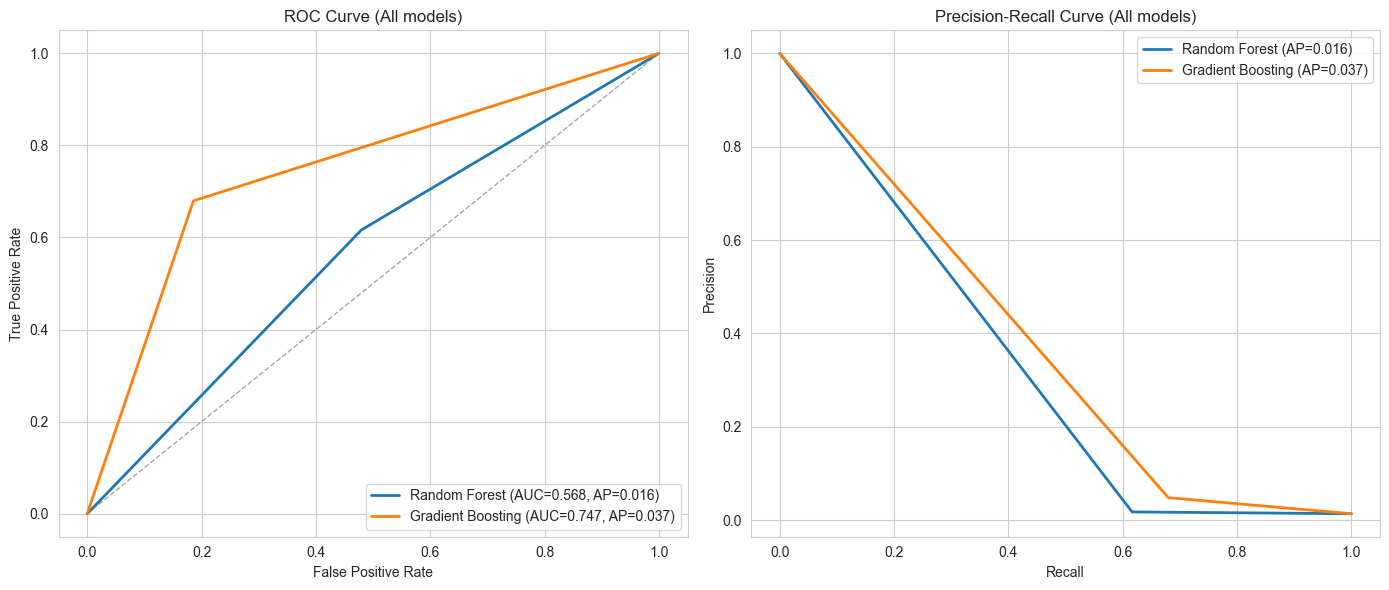

In [84]:
models = [
    ("Random Forest", y_val_pred_rf),
    ("Gradient Boosting", y_val_pred_gb),
]

metrics = []
for name, y_pred in models:
    auc_ = roc_auc_score(y_val, y_pred)
    ap_ = average_precision_score(y_val, y_pred)
    metrics.append((name, y_pred, auc_, ap_))

sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# ROC subplot
ax_roc = axs[0]
for name, y_pred, auc_, ap_ in metrics:
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    ax_roc.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_:.3f}, AP={ap_:.3f})")
ax_roc.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--", alpha=0.7)
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_title("ROC Curve (All models)")
ax_roc.legend(loc="lower right")
ax_roc.grid(True)

# Precision-Recall subplot
ax_pr = axs[1]
for name, y_pred, auc_, ap_ in metrics:
    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    ax_pr.plot(recall, precision, lw=2, label=f"{name} (AP={ap_:.3f})")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.set_title("Precision-Recall Curve (All models)")
ax_pr.legend(loc="upper right")
ax_pr.grid(True)

fig.tight_layout()
plt.show()

#### Model selection

After applying SMOTE to handle class imbalance, both models show a significant improvement in detecting the minority class.
Gradient Boosting has higher AUC and F1-score, which demonstrates that it generalizes better and provides more reliable predictions. Therefore, Gradient Boosting is selected as the final model.